## **Imports**

In [2]:
USING_COLAB = True

In [3]:
if USING_COLAB:
  %pip install pytorch_tabnet -q

    # loading data
  !gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
  !gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
  !gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
  !gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
  !gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.7 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
To: /content/graph.csv
100% 5.75M/5.75M [00:00<00:00, 23.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
To: /content/submission.csv
100% 131k/131k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
To: /content/test2_X.csv
100% 40.0M/40.0M [00:00<00:00, 56.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
To: /content/train_X.csv
100% 87.8M/87.8M [00:01<00:00, 71.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo
To: /content/train_y.csv
100% 514k/514k [00:00<00:00, 137MB/s]


In [4]:
# Other tools
import pickle
import random
import os

from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
from sklearn.model_selection import KFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import lightgbm as lgb
import xgboost as xgb


from pytorch_tabnet.tab_model import TabNetClassifier
import torch

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 69
set_seed(SEED)

## **New preprocessing function**

In [6]:
def preprocess_data(train, test, delete_corr_features=True, scale=True, init_features2drop=None):

    ts_features2drop = ['agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W', 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__8W', 'agg_cec_requests__g_contract__request_id__all__count__4W', 'agg_cec_requests__g_contract__request_id__all__count__5W', 'agg_cec_requests__g_contract__request_id__all__count__7W', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__request_id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M', 'agg_ks2__g_contract__id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__12W', 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M', 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__4W', 'agg_workers__g_contract__fact_workers__all__mean__3W', 'agg_workers__g_contract__fact_workers__all__mean__26W', 'agg_workers__g_contract__fact_workers__all__mean__6W', 'agg_workers__g_contract__fact_workers__all__mean__12W', 'agg_workers__g_contract__fact_workers__all__mean__8W', 'agg_workers__g_contract__fact_workers__all__mean__5W', 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME', 'agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__6W', 'agg_spass_applications__g_contract__appl_count_week__mean__26W', 'agg_spass_applications__g_contract__appl_count_week__max__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__12W', 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__4W', 'agg_spass_applications__g_contract__appl_count_week__mean__4W', 'agg_payments__g_contract__sum__all__countDistinct__2W', 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME', 'agg_ks2__g_contract__id__all__count__2W', 'agg_ks2__g_contract__id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__4W', 'agg_ks2__g_contract__id__all__count__4W', 'agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W', 'agg_payments__g_contract__sum__all__countDistinct__12W', 'agg_payments__g_contract__sum__all__sum__8W', 'agg_materials__g_contract__order_id__countDistinct__12W', 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__8W', 'agg_payments__g_contract__sum__all__countDistinct__ALL_TIME', 'agg_payments__g_contract__date__advance__min__ALL_TIME', 'agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_ks2__g_contract__total_sum__all__sum__8W', 'agg_ks2__g_contract__id__all__count__12W', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M', 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__1W', 'agg_sroomer__g_contractor__sroomer_id__count__12M', 'agg_sroomer__g_contractor__sroomer_id__count__6M', 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME', 'agg_sroomer__g_contractor__sroomer_id__count__3M', 'agg_ks2__g_contract__total_sum__all__sum__12W', 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__1W']
    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    if delete_corr_features:
        train = train.drop(columns=ts_features2drop)
        test = test.drop(columns=ts_features2drop)

    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = imp.transform(train[col].values.reshape(-1, 1))
            test[col] = imp.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns

    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])


    if init_features2drop is not None:
      train = train.drop(columns=[col for col in train.columns if col in init_features2drop])
      test = test.drop(columns=[col for col in train.columns if col in init_features2drop])

    return train, test, constant_features_names

## **Loading and preprocess data**

In [7]:
if not USING_COLAB:
  root_data_path = "data_partfinal"
else:
  root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

y_train_all = train["default6"]
train_orig = deepcopy(train)

In [8]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v2.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [9]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [10]:
for_drop = ["project_id", "contractor_id"]
cat_features = ["specialization_id"]

for_drop += ['agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_sroomer__g_contractor__sroomer_id__count__12M',
 'agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
 'counteragent_mean_agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'building_id',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']


train, test, constant_features_names = preprocess_data(
    train.copy(),
    test.copy(),
    delete_corr_features=False,
    scale=False,
    init_features2drop=for_drop,
)

In [11]:
from pytorch_tabnet.metrics import Metric

class Gini(Metric):
    def __init__(self):
        self._name = "gini"
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return max(2*auc - 1, 0.)

In [22]:
def fit_one_fold(t_X, t_y, v_X, v_y):

  clf= TabNetClassifier(
      optimizer_fn=torch.optim.AdamW,
      scheduler_params={
          "step_size": 5,
          "gamma": 0.9
      },
      optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
      scheduler_fn=torch.optim.lr_scheduler.StepLR,
      cat_idxs=[2],
      cat_emb_dim=[2],
      cat_dims=[32]
  )

  clf.fit(
      X_train.values,y_train.values,
      eval_set=[(t_X.values, t_y.values), (v_X.values, v_y.values)],
      eval_name=['train', 'test'],
      eval_metric=[Gini],
      max_epochs=50,
      patience=10,
      batch_size=256,
      virtual_batch_size=256,
      num_workers=4,
      weights=1,
      drop_last=False
  )

  preds = clf.predict_proba(v_X.values)[:, 1]

  return preds, clf




In [23]:
import sklearn
import warnings
warnings.filterwarnings('ignore')
tab_models = []
tab_scores = []

kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_index, test_index) in enumerate(
          kf.split(
              X=train.drop("default6", axis=1),
              y=train["default6"],
              groups=train["contract_id"])
          ):


    print(f"{'*' * 20}\nFOLD {fold}\n{'-' * 20}")

    X_train, X_valid, y_train, y_valid = train.iloc[train_index].drop("default6", axis=1), \
                                         train.iloc[test_index].drop("default6", axis=1), \
                                         train.iloc[train_index]["default6"], \
                                         train.iloc[test_index]["default6"]

    dates_features = [col for col in X_train.columns if 'date_' in col or '_date' in col]

    X_train.drop(columns=["contract_id"], inplace=True)
    X_valid.drop(columns=["contract_id"], inplace=True)

    # X_train.drop(["contract_id"] + ['contractor_id'] + constant_features_names + dates_features, axis=1, inplace=True)
    # X_valid.drop(["contract_id"] + ['contractor_id'] + constant_features_names + dates_features, axis=1, inplace=True)

    # X_train.drop(["contract_id"] + ['contractor_id', 'report_date_month', 'contract_date_month', 'contract_date', 'report_date'], axis=1, inplace=True)
    # X_valid.drop(["contract_id"] + ['contractor_id', 'report_date_month', 'contract_date_month', 'contract_date', 'report_date'], axis=1, inplace=True)

    preds, cur_model = fit_one_fold(X_train, y_train, X_valid, y_valid)
    tab_models.append(cur_model)
    tab_score = 2 * roc_auc_score(y_valid, preds) - 1
    tab_scores.append(tab_score)

    print(f"{'*' * 20}\nFOLD {fold} results:")
    print(f"catboost score: {tab_score}")
    print(f"{'-' * 20}")


********************
FOLD 0
--------------------
epoch 0  | loss: 0.68816 | train_gini: 0.11622 | test_gini: 0.09356 |  0:00:06s
epoch 1  | loss: 0.63428 | train_gini: 0.29574 | test_gini: 0.26238 |  0:00:10s
epoch 2  | loss: 0.60303 | train_gini: 0.11668 | test_gini: 0.05859 |  0:00:15s
epoch 3  | loss: 0.56012 | train_gini: 0.21091 | test_gini: 0.0847  |  0:00:21s
epoch 4  | loss: 0.51172 | train_gini: 0.40109 | test_gini: 0.21015 |  0:00:26s
epoch 5  | loss: 0.47981 | train_gini: 0.6349  | test_gini: 0.26839 |  0:00:31s
epoch 6  | loss: 0.44304 | train_gini: 0.72012 | test_gini: 0.35354 |  0:00:36s
epoch 7  | loss: 0.42171 | train_gini: 0.77383 | test_gini: 0.31562 |  0:00:41s
epoch 8  | loss: 0.39294 | train_gini: 0.80769 | test_gini: 0.35436 |  0:00:47s
epoch 9  | loss: 0.35777 | train_gini: 0.86118 | test_gini: 0.33263 |  0:00:51s
epoch 10 | loss: 0.34077 | train_gini: 0.86566 | test_gini: 0.37955 |  0:00:56s
epoch 11 | loss: 0.32855 | train_gini: 0.87006 | test_gini: 0.37938 |  

## **Inference**

In [25]:
test_preds = {"tabnet" : []}

for fold, tab_model in enumerate(
      tab_models
    ):

# for fold, cat_model in enumerate(cat_models):

  #getting preds
  tab_p = tab_model.predict_proba(test.drop(columns='contract_id').values)[:, 1]

  test_preds["tabnet"].append(tab_p)

In [33]:
test_preds["tabnet"]

[array([3.7559427e-02, 3.4359349e-34, 3.4359349e-34, ..., 2.2710433e-02,
        4.2994116e-02, 4.2994116e-02], dtype=float32),
 array([0.8018391, 0.8018391, 0.8018391, ..., 0.4129832, 0.9879941,
        0.9879941], dtype=float32),
 array([8.51504137e-06, 4.81808122e-04, 3.64273530e-03, ...,
        1.31213255e-05, 1.71470037e-05, 1.71470037e-05], dtype=float32),
 array([1.607287e-04, 1.589663e-04, 1.589663e-04, ..., 9.910650e-06,
        9.910650e-06, 9.910650e-06], dtype=float32),
 array([0.473361  , 0.00463358, 0.00463358, ..., 0.39638248, 0.38900942,
        0.39259884], dtype=float32)]

In [37]:
tab_scores_ = tab_scores[:4] + [0]
tab_final_p =  sum([w * p for w, p in zip(tab_scores_, test_preds["tabnet"])]) / sum(tab_scores_)

<Axes: ylabel='Count'>

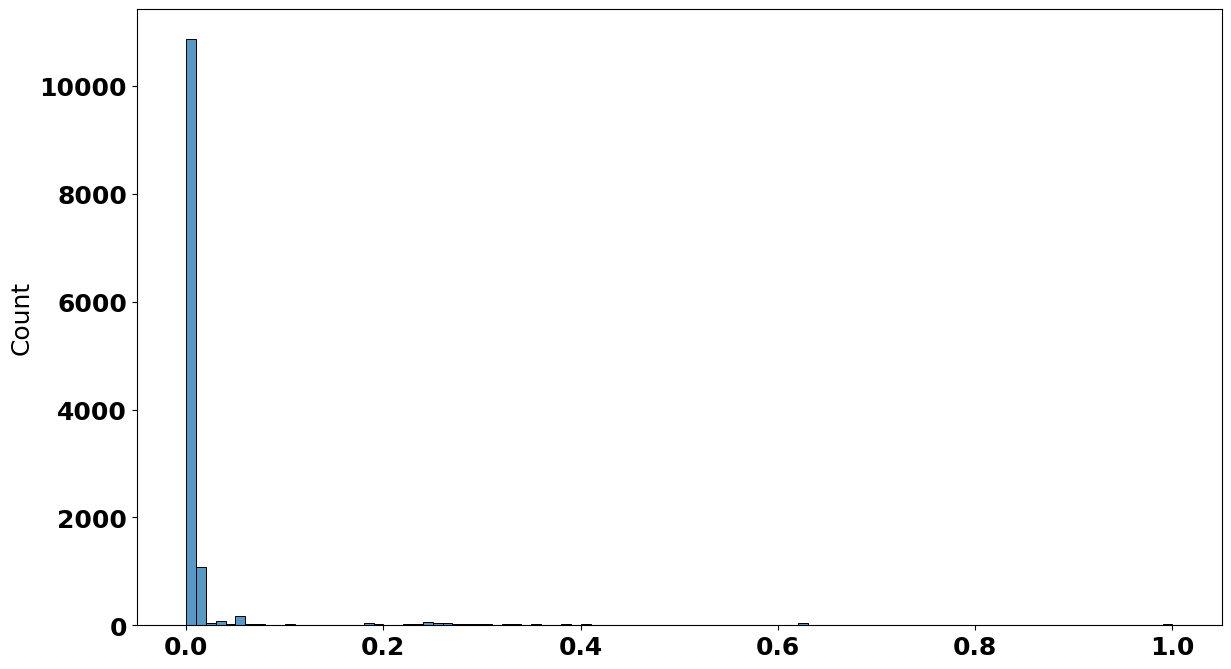

In [40]:
sns.histplot(
    test_preds["tabnet"][2],
    bins=100,
)

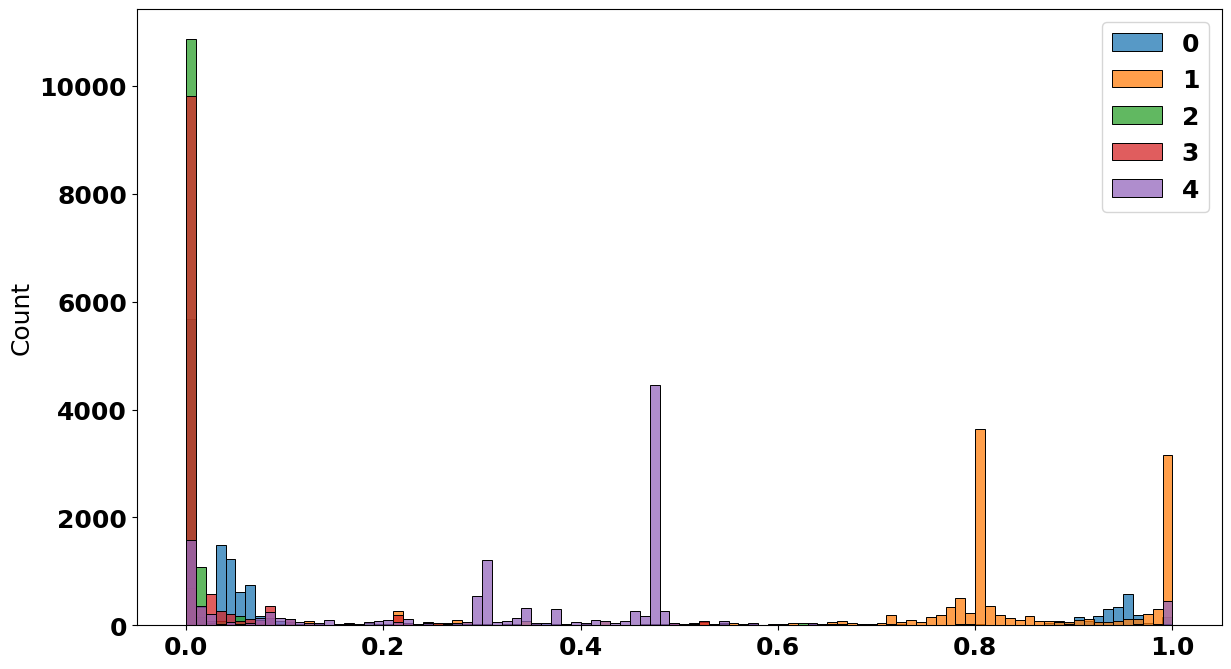

In [36]:
for i in range(5):
  sns.histplot(
      test_preds["tabnet"][i],
      bins=100,
      label=f'{i}'
  )
plt.legend()

In [41]:
sample_submit = deepcopy(pd.read_csv('test2_X.csv')[["contract_id", "report_date"]])

make_res_inv = False

if make_res_inv:
  tab_final_p = 1 - tab_final_p

sample_submit["score"] = test_preds["tabnet"][2]

print(sample_submit.head(5))

   contract_id report_date     score
0         3029  2023-07-30  0.000009
1         4350  2023-07-30  0.000482
2         1095  2023-07-30  0.003643
3         2634  2023-07-30  0.000012
4         6535  2023-07-30  0.000009


In [42]:
if USING_COLAB:
  subs_path = "/content/subs"
else:
  subs_path = "subs"

if not os.path.exists(subs_path):
  os.mkdir(subs_path)

sub_name = "tabnet_3"
sample_submit.to_csv(f"{subs_path}/{sub_name}.csv", index=False)